In [7]:
import json
import sys
import os
from collections import defaultdict
import torch
from transformers import AutoModel, AutoTokenizer
from sklearn.cluster import KMeans
import numpy as np
import json
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report
sys.path.append(os.path.join('../pstal-etu/lib/'))
from conllulib import CoNLLUReader
from torch.utils.data import DataLoader
from umap import UMAP
from sklearn.preprocessing import LabelEncoder
import seaborn as sns 
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
path = '.'

# DATA

In [8]:
with open("embeddings_cam.json") as file :
    data = json.load(file)

print (len(data))

48655


38532


[]

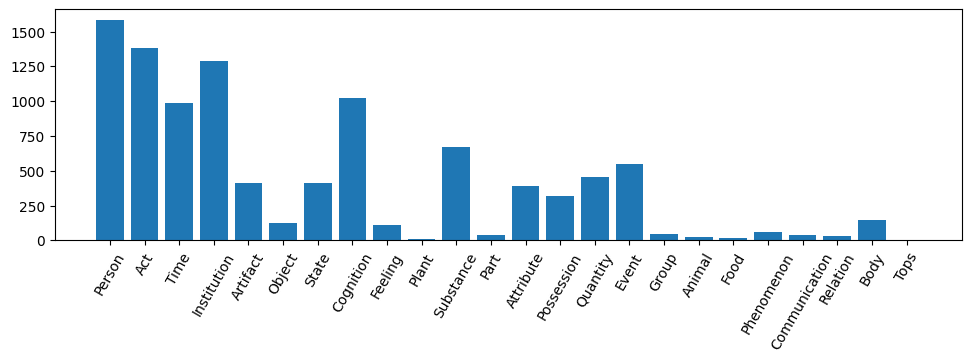

In [11]:
with open("embeddings_cam.json") as file :
    data = json.load(file)
with open("mapping_cam.json",'r') as file : 
    mapping = json.load(file)
map_inv = {value:key for key, value in mapping.items()}
cpt = defaultdict(int)
for e in data : 
    cpt[e["class"]] +=1
# for key, values in cpt.items() : 
#     print(key, values)
print(cpt[1])
cpt.pop(1)# enlève la classe '*'
plt.figure(figsize=(11.7, 3))
plt.bar([map_inv[key] for key in cpt.keys()], [cpt[key] for key in cpt.keys()])
plt.xticks(rotation=60)
plt.plot()

## Umap

/home/baptiste/micromamba/envs/cours/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


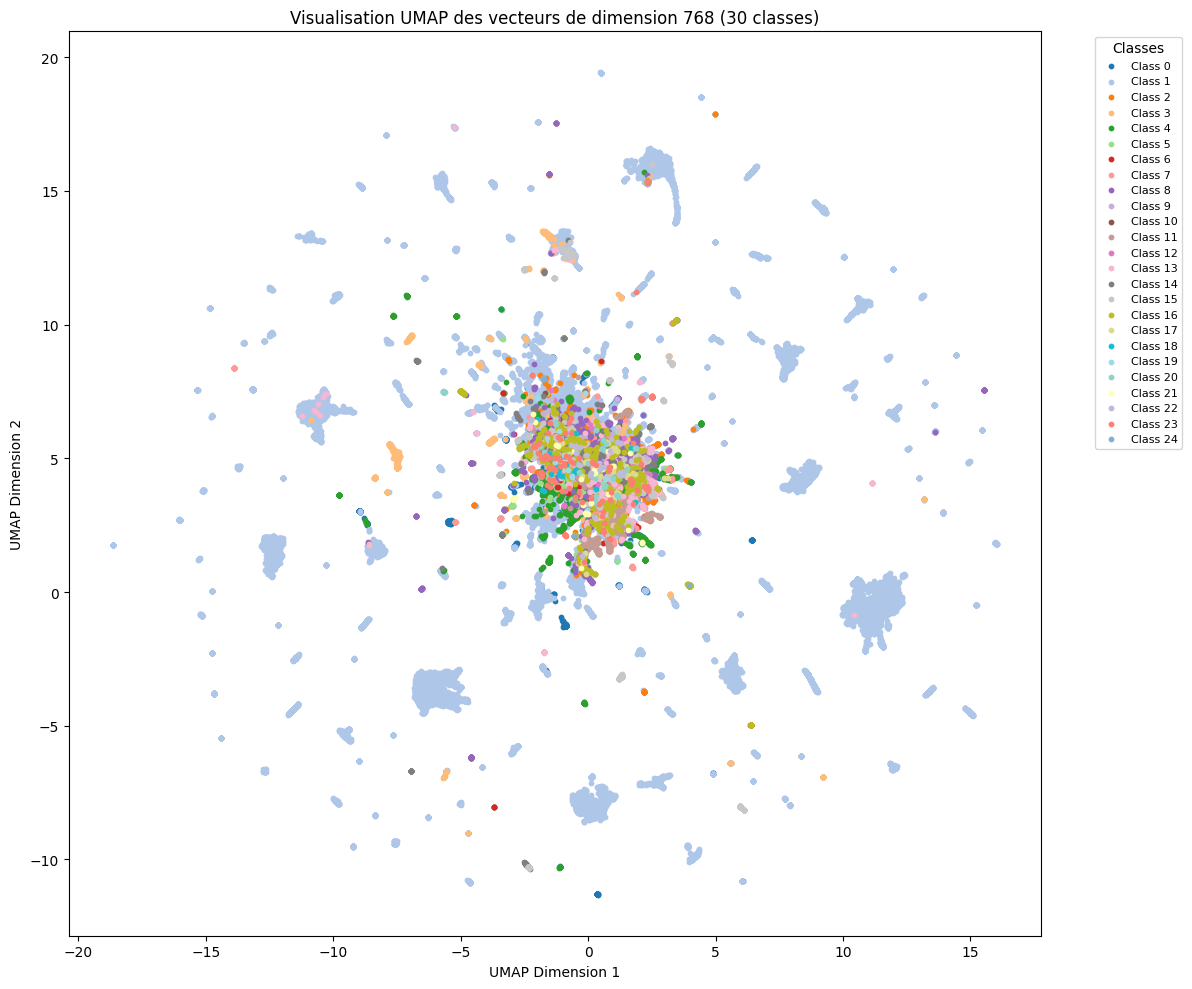

In [4]:
with open("embeddings_goo.json") as file :
    raw = json.load(file)

data = np.array([e['embedding'] for e in raw]) 
labels = np.array([e['class'] for e in raw]) 

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

palette = sns.color_palette("tab20", n_colors=20) + sns.color_palette("Set3", n_colors=10)
palette = palette[:30]  


umap_model = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
reduced_data = umap_model.fit_transform(data)

plt.figure(figsize=(12, 10))
for label in np.unique(encoded_labels):
    mask = encoded_labels == label
    plt.scatter(reduced_data[mask, 0], reduced_data[mask, 1], label=f"Class {label}", 
                color=palette[label], s=10)

plt.title("Visualisation UMAP des vecteurs de dimension 768 (30 classes)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Classes", fontsize=8)
plt.tight_layout()
plt.show()


In [9]:
%matplotlib tk

In [10]:
umap_model = UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42)
reduced_data = umap_model.fit_transform(data)


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for label in np.unique(encoded_labels):
    mask = encoded_labels == label
    ax.scatter(
        reduced_data[mask, 0], reduced_data[mask, 1], reduced_data[mask, 2], 
        label=f"Class {label}", color=palette[label], s=10
    )

ax.set_title("Visualisation UMAP en 3D des vecteurs de dimension 768 (30 classes)")
ax.set_xlabel("UMAP Dimension 1")
ax.set_ylabel("UMAP Dimension 2")
ax.set_zlabel("UMAP Dimension 3")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Classes", fontsize=8)
plt.tight_layout()
plt.show()

/home/baptiste/micromamba/envs/cours/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


# **MLP**

## **Camembert**

In [57]:

tokenizer = AutoTokenizer.from_pretrained('almanach/camembert-base')
model = AutoModel.from_pretrained('almanach/camembert-base')

file_train = os.path.join(path, '../pstal-etu/sequoia/sequoia-ud.parseme.frsemcor.simple.train')
file_test = os.path.join(path, '../pstal-etu/sequoia/sequoia-ud.parseme.frsemcor.simple.dev')



In [60]:
def dataloader(file, mapping = None):
    """
    Dataloader : charge un fichier CoNLLU, calcule des embeddings pour les mots
    et associe les embeddings aux labels. Si un mot est décomposé en tokens,
    l'embedding est la moyenne des embeddings des tokens du mot.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    data = []
    create_map = False
    if not mapping : 
        # ne pas mettre de mapping sur le train pour créer la map global et réutiliser le mapping du train sur le test et l'éval
        mapping = {}
        create_map = True
    with open(file, 'r') as file:
        reader = CoNLLUReader(file)
        for sent in reader.readConllu():
            mots = [tok["form"] for tok in sent]
            labels = [tok["frsemcor:noun"] for tok in sent]
            label_idx = [i for i in range(len(labels))]

            if create_map:
                for i in label_idx:
                    if labels[i] not in mapping:
                        mapping[labels[i]] = len(mapping)

            token_obj = tokenizer(mots, is_split_into_words=True, return_tensors='pt')
            word_ids = token_obj.word_ids()
            with torch.no_grad():
                embeddings = model(**token_obj)["last_hidden_state"]

            # calcul des embeddings moyens par mot
            word_embeddings = []
            for word_idx in range(len(mots)):
                token_indices = [i for i, w_id in enumerate(word_ids) if w_id == word_idx]
                if token_indices:
                    avg_embedding = embeddings[:, token_indices, :].mean(dim=1).squeeze(0)
                    word_embeddings.append(avg_embedding)
                else:
                    word_embeddings.append(torch.zeros(embeddings.size(-1)).to(device)) 

            # associer les embeddings moyens aux labels
            for i in label_idx:
                if labels[i] in mapping: 
                    data.append((word_embeddings[i], mapping[labels[i]]))
    return data, mapping

In [58]:
class MLP(nn.Module):
    def __init__(self, embedding_size, h1, h2, nb_tags):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features=embedding_size, out_features=h1)
        self.fc2 = nn.Linear(in_features=h1, out_features=h2)
        self.fc3 = nn.Linear(in_features=h2, out_features=nb_tags)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [68]:
def train_with_metrics(model_nn, trainloader, validateloader, loss_fn, n_epochs, optimizer):
    """
    Fonction d'entraînement du modèle avec calcul d'accuracy.
    :param model_nn: modèle de type nn.Module
    :param trainloader: DataLoader pour l'entraînement
    :param validateloader: DataLoader pour la validation
    :param loss_fn: fonction de perte
    :param n_epochs: nombre d'époques
    :param optimizer: optimiseur
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_nn = model_nn.to(device)
    losses = []
    accuracies = []

    for epoch in range(n_epochs):
        # entraînement
        model_nn.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model_nn(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct_train += (preds == targets).sum().item()
            total_train += targets.size(0)
        train_accuracy = correct_train / total_train

    #     #  validation
    #     model_nn.eval()
    #     val_loss = 0.0
    #     correct_val = 0
    #     total_val = 0
    #     with torch.no_grad():
    #         for inputs, targets in validateloader:
    #             inputs, targets = inputs.to(device), targets.to(device)
    #             outputs = model_nn(inputs)
    #             val_loss += loss_fn(outputs, targets).item()
    #             preds = torch.argmax(outputs, dim=1)
    #             correct_val += (preds == targets).sum().item()
    #             total_val += targets.size(0)
    #     val_accuracy = correct_val / total_val
        
    #     train_loss /= len(trainloader)
    #     val_loss /= len(validateloader)
    #     losses.append(val_loss)
    #     accuracies.append(val_accuracy)

    #     print(f"Époque {epoch + 1}/{n_epochs} : "
    #           f"Perte entraînement = {train_loss:.4f}, "
    #           f"Accuracy entraînement = {train_accuracy:.4f}, "
    #           f"Perte validation = {val_loss:.4f}, "
    #           f"Accuracy validation = {val_accuracy:.4f}")

    # print("Entraînement terminé.")
    # return losses, accuracies


In [78]:
data_train, mapping = dataloader(file_train)
data_eval, _ = dataloader(file_test, mapping)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
proportions = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
num_experiments = 5  

all_accuracies = []


for proportion in proportions:
    proportion_accuracies = []

    for experiment in range(num_experiments):
        print(f"Proportion: {proportion}, Expérience: {experiment + 1}/{num_experiments}")

        # sous-ensembles de données d'entraînement
        subset_size = int(len(data_train) * proportion)
        subset_train = data_train[:subset_size]
        trainloader = DataLoader(subset_train, batch_size=10, shuffle=True)
        evalloader = DataLoader(data_eval, batch_size=10, shuffle=True)

        mlp = MLP(768, 200, 200, len(mapping))
        optimizer = torch.optim.SGD(mlp.parameters(), lr=0.01)
        loss = nn.CrossEntropyLoss()

        # _, accuracies = train_with_metrics(mlp, trainloader, evalloader, loss, 10, optimizer)
        train_with_metrics(mlp, trainloader, evalloader, loss, 10, optimizer)
        l = 0
        correct = 0
        for input, target in data_eval:
            input = torch.tensor(input).to(device)
            if target != 1:
                l+=1
                pred = torch.argmax(mlp(input))
                if target ==pred:
                    correct +=1

        accuracie = correct/l
        # Stockage du dernier score d'accuracy
        proportion_accuracies.append(accuracie)
        all_accuracies.append((proportion, accuracie))


torch.save(mlp, "mlp.pth")
mapping = dict(mapping)
with open("mapping.json", "w") as file: 
    json.dump(mapping, file, indent=4)


Proportion: 0.2, Expérience: 1/5


/tmp/ipykernel_7334/500461424.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input).to(device)


Proportion: 0.2, Expérience: 2/5
Proportion: 0.2, Expérience: 3/5
Proportion: 0.2, Expérience: 4/5
Proportion: 0.2, Expérience: 5/5
Proportion: 0.3, Expérience: 1/5
Proportion: 0.3, Expérience: 2/5
Proportion: 0.3, Expérience: 3/5
Proportion: 0.3, Expérience: 4/5
Proportion: 0.3, Expérience: 5/5
Proportion: 0.4, Expérience: 1/5
Proportion: 0.4, Expérience: 2/5
Proportion: 0.4, Expérience: 3/5
Proportion: 0.4, Expérience: 4/5
Proportion: 0.4, Expérience: 5/5
Proportion: 0.5, Expérience: 1/5
Proportion: 0.5, Expérience: 2/5
Proportion: 0.5, Expérience: 3/5
Proportion: 0.5, Expérience: 4/5
Proportion: 0.5, Expérience: 5/5
Proportion: 0.6, Expérience: 1/5
Proportion: 0.6, Expérience: 2/5
Proportion: 0.6, Expérience: 3/5
Proportion: 0.6, Expérience: 4/5
Proportion: 0.6, Expérience: 5/5
Proportion: 0.7, Expérience: 1/5
Proportion: 0.7, Expérience: 2/5
Proportion: 0.7, Expérience: 3/5
Proportion: 0.7, Expérience: 4/5
Proportion: 0.7, Expérience: 5/5
Proportion: 0.8, Expérience: 1/5
Proportion

In [79]:
with open("liste_result_cam.txt",'w') as file:
    file.write(str(all_accuracies))

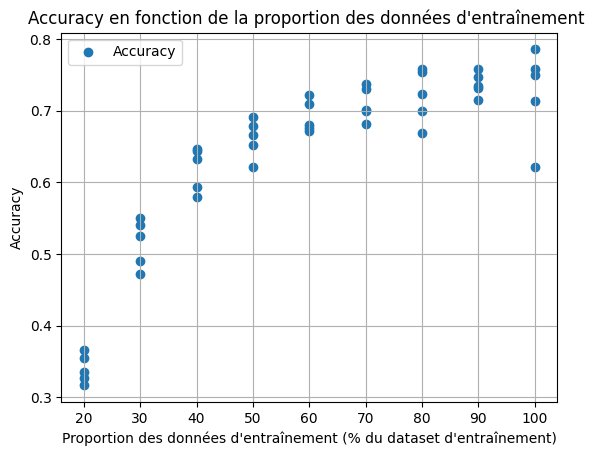

In [80]:
plt.scatter(np.array([e[0] for e in all_accuracies])*100, [e[1] for e in all_accuracies], marker='o', label="Accuracy")
plt.title("Accuracy en fonction de la proportion des données d'entraînement ")
plt.xlabel("Proportion des données d'entraînement (% du dataset d'entraînement)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

/tmp/ipykernel_7334/929750505.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grouped_accuracies, labels=[f"{p:.0f}%" for p in unique_proportions])


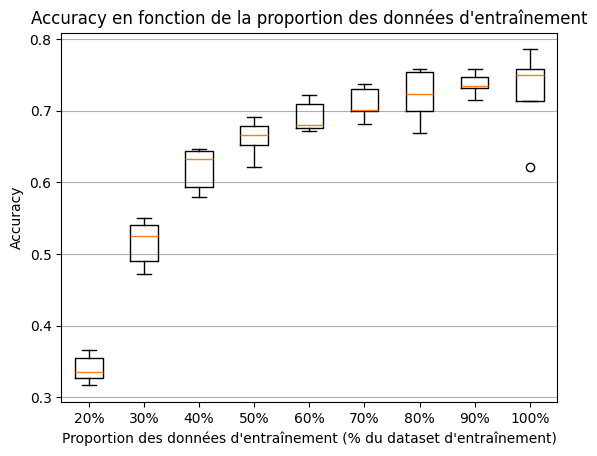

In [81]:
proportions = np.array([e[0] for e in all_accuracies]) * 100
accuracy_values = [e[1] for e in all_accuracies]


unique_proportions = sorted(set(proportions))
grouped_accuracies = [
    [accuracy_values[i] for i in range(len(proportions)) if proportions[i] == p]
    for p in unique_proportions
]
plt.boxplot(grouped_accuracies, labels=[f"{p:.0f}%" for p in unique_proportions])

plt.title("Accuracy en fonction de la proportion des données d'entraînement")
plt.xlabel("Proportion des données d'entraînement (% du dataset d'entraînement)")
plt.ylabel("Accuracy")
plt.grid(axis='y')
plt.show()

## **GoogleBert**

In [15]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased') # ('almanach/camembert-base')
model = AutoModel.from_pretrained('bert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


file_train = os.path.join(path, '../pstal-etu/sequoia/sequoia-ud.parseme.frsemcor.simple.train')
file_test = os.path.join(path, '../pstal-etu/sequoia/sequoia-ud.parseme.frsemcor.simple.dev')


In [16]:
def dataloader(file, mapping = None):
    """
    Dataloader : charge un fichier CoNLLU, calcule des embeddings pour les mots
    et associe les embeddings aux labels. Si un mot est décomposé en tokens,
    l'embedding est la moyenne des embeddings des tokens du mot.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    data = []
    create_map = False
    if not mapping : 
        # ne pas mettre de mapping sur le train pour créer la map global et réutiliser le mapping du train sur le test et l'éval
        mapping = {}
        create_map = True
    with open(file, 'r') as file:
        reader = CoNLLUReader(file)
        for sent in reader.readConllu():
            mots = [tok["form"] for tok in sent]
            labels = [tok["frsemcor:noun"] for tok in sent]
            label_idx = [i for i in range(len(labels))]

            if create_map:
                for i in label_idx:
                    if labels[i] not in mapping:
                        mapping[labels[i]] = len(mapping)

            token_obj = tokenizer(mots, is_split_into_words=True, return_tensors='pt')
            word_ids = token_obj.word_ids()
            with torch.no_grad():
                embeddings = model(**token_obj)["last_hidden_state"]

            # calcul des embeddings moyens par mot
            word_embeddings = []
            for word_idx in range(len(mots)):
                token_indices = [i for i, w_id in enumerate(word_ids) if w_id == word_idx]
                if token_indices:
                    avg_embedding = embeddings[:, token_indices, :].mean(dim=1).squeeze(0)
                    word_embeddings.append(avg_embedding)
                else:
                    word_embeddings.append(torch.zeros(embeddings.size(-1)).to(device)) 

            # associer les embeddings moyens aux labels
            for i in label_idx:
                if labels[i] in mapping: 
                    data.append((word_embeddings[i], mapping[labels[i]]))
    return data, mapping

In [10]:
class MLP(nn.Module):
    def __init__(self, embedding_size, h1, h2, nb_tags):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features=embedding_size, out_features=h1)
        self.fc2 = nn.Linear(in_features=h1, out_features=h2)
        self.fc3 = nn.Linear(in_features=h2, out_features=nb_tags)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [11]:
def train_with_metrics(model_nn, trainloader, validateloader, loss_fn, n_epochs, optimizer):
    """
    Fonction d'entraînement du modèle avec calcul d'accuracy.
    :param model_nn: modèle de type nn.Module
    :param trainloader: DataLoader pour l'entraînement
    :param validateloader: DataLoader pour la validation
    :param loss_fn: fonction de perte
    :param n_epochs: nombre d'époques
    :param optimizer: optimiseur
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_nn = model_nn.to(device)
    losses = []
    accuracies = []

    for epoch in range(n_epochs):
        # entraînement
        model_nn.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model_nn(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct_train += (preds == targets).sum().item()
            total_train += targets.size(0)
        train_accuracy = correct_train / total_train

    #     #  validation
    #     model_nn.eval()
    #     val_loss = 0.0
    #     correct_val = 0
    #     total_val = 0
    #     with torch.no_grad():
    #         for inputs, targets in validateloader:
    #             inputs, targets = inputs.to(device), targets.to(device)
    #             outputs = model_nn(inputs)
    #             val_loss += loss_fn(outputs, targets).item()
    #             preds = torch.argmax(outputs, dim=1)
    #             correct_val += (preds == targets).sum().item()
    #             total_val += targets.size(0)
    #     val_accuracy = correct_val / total_val
        
    #     train_loss /= len(trainloader)
    #     val_loss /= len(validateloader)
    #     losses.append(val_loss)
    #     accuracies.append(val_accuracy)

    #     print(f"Époque {epoch + 1}/{n_epochs} : "
    #           f"Perte entraînement = {train_loss:.4f}, "
    #           f"Accuracy entraînement = {train_accuracy:.4f}, "
    #           f"Perte validation = {val_loss:.4f}, "
    #           f"Accuracy validation = {val_accuracy:.4f}")

    # print("Entraînement terminé.")
    # return losses, accuracies


In [17]:
data_train, mapping = dataloader(file_train)
data_eval, _ = dataloader(file_test, mapping)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
proportions = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
num_experiments = 5  

all_accuracies = []


for proportion in proportions:
    proportion_accuracies = []

    for experiment in range(num_experiments):
        print(f"Proportion: {proportion}, Expérience: {experiment + 1}/{num_experiments}")

        # sous-ensembles de données d'entraînement
        subset_size = int(len(data_train) * proportion)
        subset_train = data_train[:subset_size]
        trainloader = DataLoader(subset_train, batch_size=10, shuffle=True)
        evalloader = DataLoader(data_eval, batch_size=10, shuffle=True)

        mlp = MLP(768, 200, 200, len(mapping))
        optimizer = torch.optim.SGD(mlp.parameters(), lr=0.01)
        loss = nn.CrossEntropyLoss()

        # _, accuracies = train_with_metrics(mlp, trainloader, evalloader, loss, 10, optimizer)
        train_with_metrics(mlp, trainloader, evalloader, loss, 10, optimizer)
        l = 0
        correct = 0
        for input, target in data_eval:
            input = torch.tensor(input).to(device)
            if target != 1: # target *
                l+=1
                pred = torch.argmax(mlp(input))
                if target ==pred:
                    correct +=1

        accuracie = correct/l
        # Stockage du dernier score d'accuracy
        proportion_accuracies.append(accuracie)
        all_accuracies.append((proportion, accuracie))


# torch.save(mlp, "mlp.pth")
# mapping = dict(mapping)
# with open("mapping.json", "w") as file: 
#     json.dump(mapping, file, indent=4)


Proportion: 0.2, Expérience: 1/5


/tmp/ipykernel_4596/189092292.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input).to(device)


Proportion: 0.2, Expérience: 2/5
Proportion: 0.2, Expérience: 3/5
Proportion: 0.2, Expérience: 4/5
Proportion: 0.2, Expérience: 5/5
Proportion: 0.3, Expérience: 1/5
Proportion: 0.3, Expérience: 2/5
Proportion: 0.3, Expérience: 3/5
Proportion: 0.3, Expérience: 4/5
Proportion: 0.3, Expérience: 5/5
Proportion: 0.4, Expérience: 1/5
Proportion: 0.4, Expérience: 2/5
Proportion: 0.4, Expérience: 3/5
Proportion: 0.4, Expérience: 4/5
Proportion: 0.4, Expérience: 5/5
Proportion: 0.5, Expérience: 1/5
Proportion: 0.5, Expérience: 2/5
Proportion: 0.5, Expérience: 3/5
Proportion: 0.5, Expérience: 4/5
Proportion: 0.5, Expérience: 5/5
Proportion: 0.6, Expérience: 1/5
Proportion: 0.6, Expérience: 2/5
Proportion: 0.6, Expérience: 3/5
Proportion: 0.6, Expérience: 4/5
Proportion: 0.6, Expérience: 5/5
Proportion: 0.7, Expérience: 1/5
Proportion: 0.7, Expérience: 2/5
Proportion: 0.7, Expérience: 3/5
Proportion: 0.7, Expérience: 4/5
Proportion: 0.7, Expérience: 5/5
Proportion: 0.8, Expérience: 1/5
Proportion

In [18]:
with open("liste_result_goo.txt",'w') as file:
    file.write(str(all_accuracies))

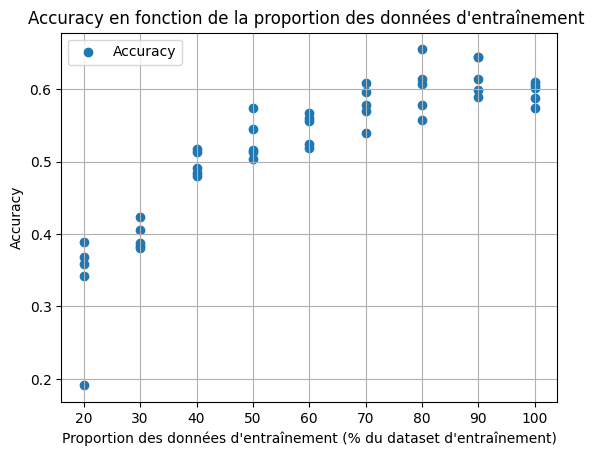

In [19]:
plt.scatter(np.array([e[0] for e in all_accuracies])*100, [e[1] for e in all_accuracies], marker='o', label="Accuracy")
plt.title("Accuracy en fonction de la proportion des données d'entraînement ")
plt.xlabel("Proportion des données d'entraînement (% du dataset d'entraînement)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

/tmp/ipykernel_4596/929750505.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grouped_accuracies, labels=[f"{p:.0f}%" for p in unique_proportions])


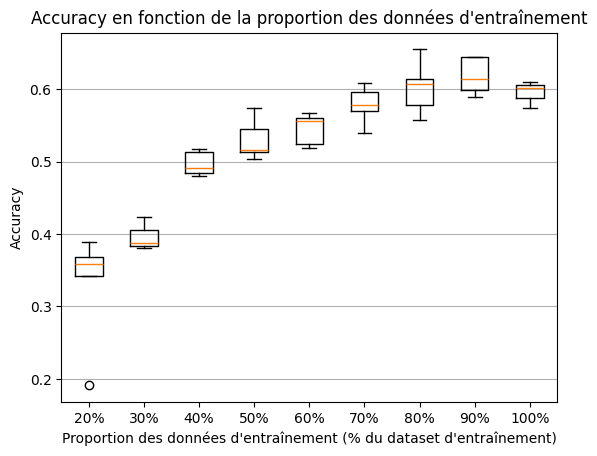

In [20]:
proportions = np.array([e[0] for e in all_accuracies]) * 100
accuracy_values = [e[1] for e in all_accuracies]


unique_proportions = sorted(set(proportions))
grouped_accuracies = [
    [accuracy_values[i] for i in range(len(proportions)) if proportions[i] == p]
    for p in unique_proportions
]
plt.boxplot(grouped_accuracies, labels=[f"{p:.0f}%" for p in unique_proportions])

plt.title("Accuracy en fonction de la proportion des données d'entraînement")
plt.xlabel("Proportion des données d'entraînement (% du dataset d'entraînement)")
plt.ylabel("Accuracy")
plt.grid(axis='y')
plt.show()

# **K-NN**

## **Camembert**

In [ ]:


# Chargement des modèles et données
model = AutoModel.from_pretrained('almanach/camembert-base')
tokenizer = AutoTokenizer.from_pretrained('almanach/camembert-base')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
k=10
with open("embeddings_cam.json", "r") as file:
    train_data = json.load(file)
with open("mapping_cam.json", "r") as file:
    mapping = json.load(file)
path = '.'
# Fonction de chargement des données de test
def dataloader_test(file):
    test_data = []
    with open(file, 'r') as f:
        reader = CoNLLUReader(f)
        for sent in reader.readConllu():
            mots = [tok["form"] for tok in sent]
            labels = [tok.get("frsemcor:noun", "") for tok in sent]
            token_obj = tokenizer(mots, is_split_into_words=True, return_tensors='pt').to(device)
            word_ids = token_obj.word_ids()
            
            with torch.no_grad():
                embeddings = model(**token_obj)["last_hidden_state"].to(device)
            
            for word_idx in range(len(mots)):
                token_indices = [i for i, w_id in enumerate(word_ids) if w_id == word_idx]
                if token_indices:
                    avg_embedding = embeddings[:, token_indices, :].mean(dim=1).squeeze(0).cpu().numpy()
                    test_data.append({
                        "word": mots[word_idx],
                        "embedding": avg_embedding.tolist(),
                        "label": mapping.get(labels[word_idx], -1)
                    })
    return test_data


file_test = os.path.join(path, '../pstal-etu/sequoia/sequoia-ud.parseme.frsemcor.simple.test')
test_data = dataloader_test(file_test)


proportions = np.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
accuracies = []


for proportion in proportions:
    for _ in range(5):
        print(f"Proportion: {proportion}")
        
    
        subset_size = int(len(train_data) * proportion)
        subset_train = random.sample(train_data, subset_size)
        
        train_embeddings = [np.array(item["embedding"]) for item in subset_train]
        train_labels = [item["class"] for item in subset_train]
        

        knn = KNeighborsClassifier(n_neighbors=k)  
        knn.fit(train_embeddings, train_labels)
        
        true_labels = []
        predicted_labels = []
        for item in test_data:
            embedding = np.array(item["embedding"])
            true_label = item["label"]
            if true_label != 1:  # ignorer les '*'
                predicted_label = knn.predict([embedding])[0]
                true_labels.append(true_label)
                predicted_labels.append(predicted_label)
        
  
        accuracy = np.mean(np.array(true_labels) == np.array(predicted_labels))
        accuracies.append((proportion, accuracy))


plt.scatter(np.array([e[0] for e in accuracies]) * 100, [e[1] for e in accuracies], marker='o', label="Accuracy")
plt.title("Accuracy en fonction de la proportion des données d'entraînement (k-NN)")
plt.xlabel("Proportion des données d'entraînement (% du dataset d'entraînement)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


proportions = np.array([e[0] for e in accuracies]) * 100
accuracy_values = [e[1] for e in accuracies]

unique_proportions = sorted(set(proportions))
grouped_accuracies = [
    [accuracy_values[i] for i in range(len(proportions)) if proportions[i] == p]
    for p in unique_proportions
]
plt.boxplot(grouped_accuracies, labels=[f"{p:.0f}%" for p in unique_proportions])
plt.title(f"Accuracy en fonction de la proportion des données d'entraînement ({k}-NN)")
plt.xlabel("Proportion des données d'entraînement (% du dataset d'entraînement)")
plt.ylabel("Accuracy")
plt.grid(axis='y')
plt.show()

## **Google-bert**

Proportion: 0.2
Proportion: 0.2
Proportion: 0.2
Proportion: 0.2
Proportion: 0.2
Proportion: 0.3
Proportion: 0.3
Proportion: 0.3
Proportion: 0.3
Proportion: 0.3
Proportion: 0.4
Proportion: 0.4
Proportion: 0.4
Proportion: 0.4
Proportion: 0.4
Proportion: 0.5
Proportion: 0.5
Proportion: 0.5
Proportion: 0.5
Proportion: 0.5
Proportion: 0.6
Proportion: 0.6
Proportion: 0.6
Proportion: 0.6
Proportion: 0.6
Proportion: 0.7
Proportion: 0.7
Proportion: 0.7
Proportion: 0.7
Proportion: 0.7
Proportion: 0.8
Proportion: 0.8
Proportion: 0.8
Proportion: 0.8
Proportion: 0.8
Proportion: 0.9
Proportion: 0.9
Proportion: 0.9
Proportion: 0.9
Proportion: 0.9
Proportion: 1.0
Proportion: 1.0
Proportion: 1.0
Proportion: 1.0
Proportion: 1.0


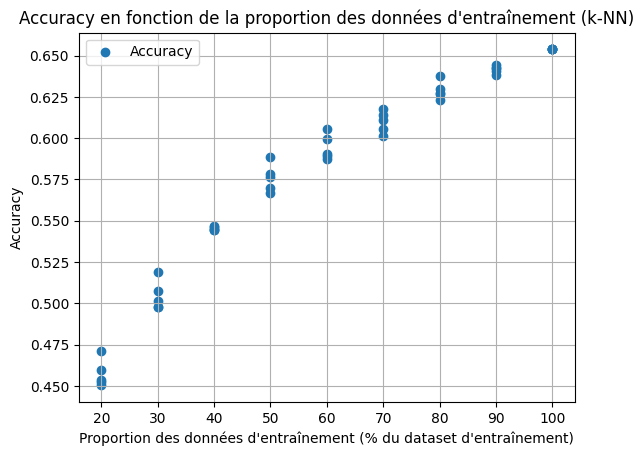

/tmp/ipykernel_12318/3957635308.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grouped_accuracies, labels=[f"{p:.0f}%" for p in unique_proportions])


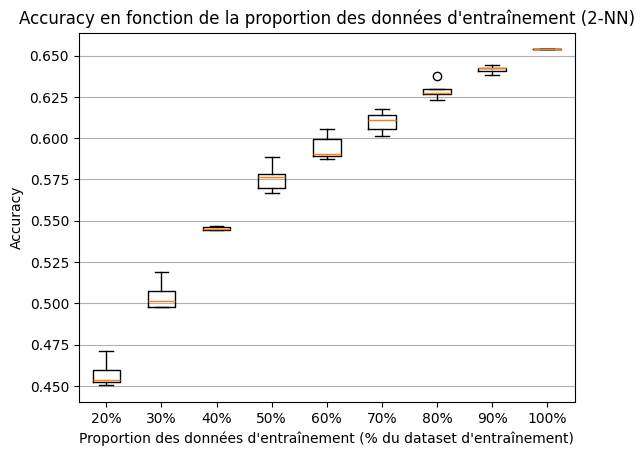

In [12]:

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased') # ('almanach/camembert-base')
model = AutoModel.from_pretrained('bert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
k=2
with open("embeddings_goo.json", "r") as file:
    train_data = json.load(file)
with open("mapping_goo.json", "r") as file:
    mapping = json.load(file)
path = '.'

def dataloader_test(file):
    test_data = []
    with open(file, 'r') as f:
        reader = CoNLLUReader(f)
        for sent in reader.readConllu():
            mots = [tok["form"] for tok in sent]
            labels = [tok.get("frsemcor:noun", "") for tok in sent]
            token_obj = tokenizer(mots, is_split_into_words=True, return_tensors='pt').to(device)
            word_ids = token_obj.word_ids()
            
            with torch.no_grad():
                embeddings = model(**token_obj)["last_hidden_state"].to(device)
            
            for word_idx in range(len(mots)):
                token_indices = [i for i, w_id in enumerate(word_ids) if w_id == word_idx]
                if token_indices:
                    avg_embedding = embeddings[:, token_indices, :].mean(dim=1).squeeze(0).cpu().numpy()
                    test_data.append({
                        "word": mots[word_idx],
                        "embedding": avg_embedding.tolist(),
                        "label": mapping.get(labels[word_idx], -1)
                    })
    return test_data


file_test = os.path.join(path, '../pstal-etu/sequoia/sequoia-ud.parseme.frsemcor.simple.test')
test_data = dataloader_test(file_test)


proportions = np.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
accuracies = []


for proportion in proportions:
    for _ in range(5):
        print(f"Proportion: {proportion}")
        
    
        subset_size = int(len(train_data) * proportion)
        subset_train = random.sample(train_data, subset_size)
        
        train_embeddings = [np.array(item["embedding"]) for item in subset_train]
        train_labels = [item["class"] for item in subset_train]
        

        knn = KNeighborsClassifier(n_neighbors=k)  
        knn.fit(train_embeddings, train_labels)
        
        true_labels = []
        predicted_labels = []
        for item in test_data:
            embedding = np.array(item["embedding"])
            true_label = item["label"]
            if true_label != 1:  # ignorer les '*'
                predicted_label = knn.predict([embedding])[0]
                true_labels.append(true_label)
                predicted_labels.append(predicted_label)
        
  
        accuracy = np.mean(np.array(true_labels) == np.array(predicted_labels))
        accuracies.append((proportion, accuracy))


plt.scatter(np.array([e[0] for e in accuracies]) * 100, [e[1] for e in accuracies], marker='o', label="Accuracy")
plt.title("Accuracy en fonction de la proportion des données d'entraînement (k-NN)")
plt.xlabel("Proportion des données d'entraînement (% du dataset d'entraînement)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


proportions = np.array([e[0] for e in accuracies]) * 100
accuracy_values = [e[1] for e in accuracies]

unique_proportions = sorted(set(proportions))
grouped_accuracies = [
    [accuracy_values[i] for i in range(len(proportions)) if proportions[i] == p]
    for p in unique_proportions
]
plt.boxplot(grouped_accuracies, labels=[f"{p:.0f}%" for p in unique_proportions])
plt.title(f"Accuracy en fonction de la proportion des données d'entraînement ({k}-NN)")
plt.xlabel("Proportion des données d'entraînement (% du dataset d'entraînement)")
plt.ylabel("Accuracy")
plt.grid(axis='y')
plt.show()

Proportion: 0.2
Proportion: 0.2
Proportion: 0.2
Proportion: 0.2
Proportion: 0.2
Proportion: 0.3
Proportion: 0.3
Proportion: 0.3
Proportion: 0.3
Proportion: 0.3
Proportion: 0.4
Proportion: 0.4
Proportion: 0.4
Proportion: 0.4
Proportion: 0.4
Proportion: 0.5
Proportion: 0.5
Proportion: 0.5
Proportion: 0.5
Proportion: 0.5
Proportion: 0.6
Proportion: 0.6
Proportion: 0.6
Proportion: 0.6
Proportion: 0.6
Proportion: 0.7
Proportion: 0.7
Proportion: 0.7
Proportion: 0.7
Proportion: 0.7
Proportion: 0.8
Proportion: 0.8
Proportion: 0.8
Proportion: 0.8
Proportion: 0.8
Proportion: 0.9
Proportion: 0.9
Proportion: 0.9
Proportion: 0.9
Proportion: 0.9
Proportion: 1.0
Proportion: 1.0
Proportion: 1.0
Proportion: 1.0
Proportion: 1.0


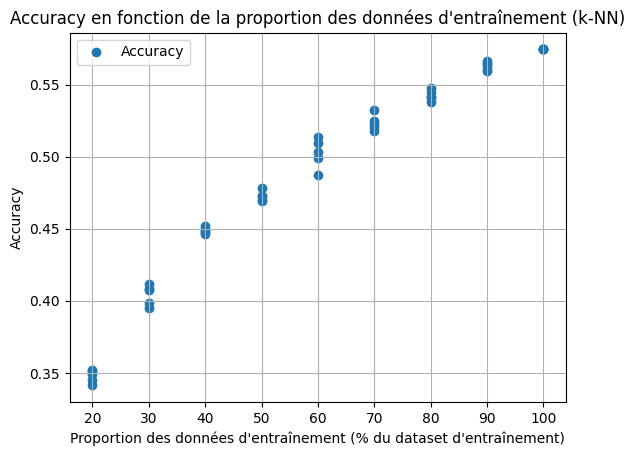

/tmp/ipykernel_12318/2030065851.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grouped_accuracies, labels=[f"{p:.0f}%" for p in unique_proportions])


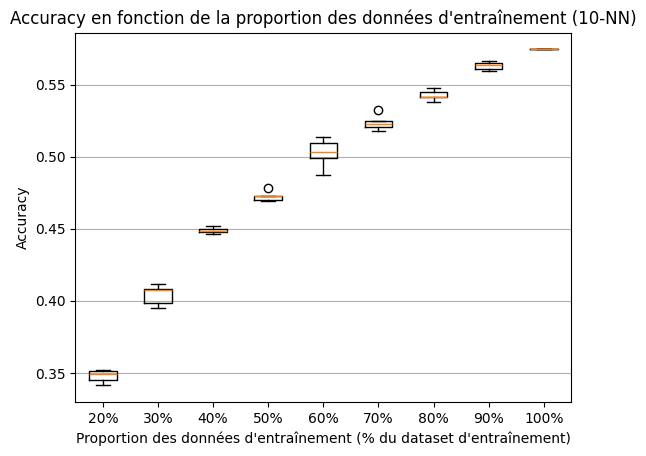

In [15]:
k=10


proportions = np.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
accuracies = []


for proportion in proportions:
    for _ in range(5):
        print(f"Proportion: {proportion}")
        
    
        subset_size = int(len(train_data) * proportion)
        subset_train = random.sample(train_data, subset_size)
        
        train_embeddings = [np.array(item["embedding"]) for item in subset_train]
        train_labels = [item["class"] for item in subset_train]
        

        knn = KNeighborsClassifier(n_neighbors=k)  
        knn.fit(train_embeddings, train_labels)
        
        true_labels = []
        predicted_labels = []
        for item in test_data:
            embedding = np.array(item["embedding"])
            true_label = item["label"]
            if true_label != 1:  # ignorer les '*'
                predicted_label = knn.predict([embedding])[0]
                true_labels.append(true_label)
                predicted_labels.append(predicted_label)
        
  
        accuracy = np.mean(np.array(true_labels) == np.array(predicted_labels))
        accuracies.append((proportion, accuracy))


plt.scatter(np.array([e[0] for e in accuracies]) * 100, [e[1] for e in accuracies], marker='o', label="Accuracy")
plt.title("Accuracy en fonction de la proportion des données d'entraînement (k-NN)")
plt.xlabel("Proportion des données d'entraînement (% du dataset d'entraînement)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


proportions = np.array([e[0] for e in accuracies]) * 100
accuracy_values = [e[1] for e in accuracies]

unique_proportions = sorted(set(proportions))
grouped_accuracies = [
    [accuracy_values[i] for i in range(len(proportions)) if proportions[i] == p]
    for p in unique_proportions
]
plt.boxplot(grouped_accuracies, labels=[f"{p:.0f}%" for p in unique_proportions])
plt.title(f"Accuracy en fonction de la proportion des données d'entraînement ({k}-NN)")
plt.xlabel("Proportion des données d'entraînement (% du dataset d'entraînement)")
plt.ylabel("Accuracy")
plt.grid(axis='y')
plt.show()

In [16]:
k=15
proportions = np.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
accuracies = []


for proportion in proportions:
    for _ in range(5):
        print(f"Proportion: {proportion}")
        
    
        subset_size = int(len(train_data) * proportion)
        subset_train = random.sample(train_data, subset_size)
        
        train_embeddings = [np.array(item["embedding"]) for item in subset_train]
        train_labels = [item["class"] for item in subset_train]
        

        knn = KNeighborsClassifier(n_neighbors=k)  
        knn.fit(train_embeddings, train_labels)
        
        true_labels = []
        predicted_labels = []
        for item in test_data:
            embedding = np.array(item["embedding"])
            true_label = item["label"]
            if true_label != 1:  # ignorer les '*'
                predicted_label = knn.predict([embedding])[0]
                true_labels.append(true_label)
                predicted_labels.append(predicted_label)
        
  
        accuracy = np.mean(np.array(true_labels) == np.array(predicted_labels))
        accuracies.append((proportion, accuracy))


plt.scatter(np.array([e[0] for e in accuracies]) * 100, [e[1] for e in accuracies], marker='o', label="Accuracy")
plt.title("Accuracy en fonction de la proportion des données d'entraînement (k-NN)")
plt.xlabel("Proportion des données d'entraînement (% du dataset d'entraînement)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


proportions = np.array([e[0] for e in accuracies]) * 100
accuracy_values = [e[1] for e in accuracies]

unique_proportions = sorted(set(proportions))
grouped_accuracies = [
    [accuracy_values[i] for i in range(len(proportions)) if proportions[i] == p]
    for p in unique_proportions
]
plt.boxplot(grouped_accuracies, labels=[f"{p:.0f}%" for p in unique_proportions])
plt.title(f"Accuracy en fonction de la proportion des données d'entraînement ({k}-NN)")
plt.xlabel("Proportion des données d'entraînement (% du dataset d'entraînement)")
plt.ylabel("Accuracy")
plt.grid(axis='y')
plt.show()

Proportion: 0.2
Proportion: 0.2
Proportion: 0.2
Proportion: 0.2
Proportion: 0.2
Proportion: 0.3
Proportion: 0.3
Proportion: 0.3
Proportion: 0.3
Proportion: 0.3
Proportion: 0.4
Proportion: 0.4
Proportion: 0.4
Proportion: 0.4
Proportion: 0.4
Proportion: 0.5
Proportion: 0.5
